In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Tue Jan 17 15:31:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "dialect"

In [ ]:
df_dialect = pd.read_csv("/content/drive/MyDrive/CIT_DL_project/downloaded_dataset/dialect_dataset_cleaned.csv")

#print()
df_dialect = df_dialect[["text","dialect"]]  # we are interested in text and dialect only
df_dialect.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_dialect[LABEL_COLUMN].value_counts())

label_list_dialect = list(df_dialect[LABEL_COLUMN].unique())
print(label_list_dialect)

train_dialect, test_dialect = train_test_split(df_dialect, test_size=0.1, random_state=42, stratify=df_dialect[LABEL_COLUMN] )

print("Training length: ", len(train_dialect))
print("Testing length: ", len(test_dialect))

data_dialect = CustomDataset("Dialect", train_dialect, test_dialect, label_list_dialect)

EG    57636
KW    42109
PL    40456
LY    36499
QA    31069
JO    27921
LB    27617
SA    26832
AE    26296
BH    26292
OM    19116
SY    16242
DZ    16183
IQ    15497
SD    14434
MA    11539
YE     9927
TN     9246
Name: dialect, dtype: int64
['TN', 'YE', 'MA', 'SD', 'IQ', 'DZ', 'SY', 'OM', 'BH', 'AE', 'LB', 'JO', 'SA', 'QA', 'KW', 'EG', 'LY', 'PL']
Training length:  409419
Testing length:  45492


# **Trainer**

In [ ]:
!pip install arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 KB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=2cc6f175cde385dd5f3f9126ba125abdf2441be1837dde4779de74b57a8a60bb
  Stored in directory: /root/.cache/pip/wheels/71/4d/3c/cada364d4ea0026deee7208dee1e61bcebd20aa2ae5dc154ba
Successfully built emoji


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [ ]:
# "bert-base-arabertv2" with FarasaSegmenter or use "bert-base-arabertv02" for no FarasaSegmenter or use apply_farasa_segmentation=True
model_name = 'aubmindlab/bert-base-arabertv02' # we are going to use the twitter AraBERT since it has emojis and dialects

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

data_dialect.train[DATA_COLUMN] = data_dialect.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
data_dialect.test[DATA_COLUMN] = data_dialect.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [ ]:
# Sanity check on the dataset
list(data_dialect.train[DATA_COLUMN][0:10])

['اخييرا عطوا العرب وجه بالتوفييق رياان',
 'حبيبتي مش هايحصل حاجه ابداا دول عباره حاجه مالهاش لازمه خساره استعداداتك فيهم',
 'ياسلاام عجبني اوي الكلام ده',
 'مافيا المولدات بدك تشوف مين المستفيد ايا جهه سياسيه',
 'ده الي مالوهش ماتشوف عيونه الضي يقضي عمره غريب وطن ولاحي كلاسيكيات',
 'كوشنر شكله يشوف افلام وايد',
 'انا زمن خدو مشلخ ازمانا خدها ساده اتلاقينا بينا فواصله عااليه قالت عيد ميلادي الشهر الجاي ولازم تحضر سودانيات',
 'عم اضحك والله اديش مقهورين مننا',
 'مسجلين سوق واقف باسمك',
 'الي اقصده الفريق محتاج استقرار بدون استقرار صعب يستمر الفريق التطور']

## Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name, 
                                    do_lower_case=False, 
                                    do_basic_tokenize=True)

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Training Sentence Lengths: 


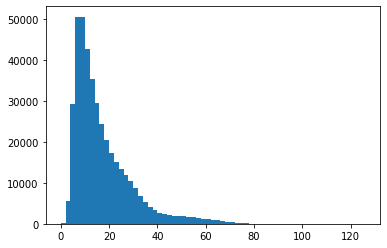

Testing Sentence Lengths: 


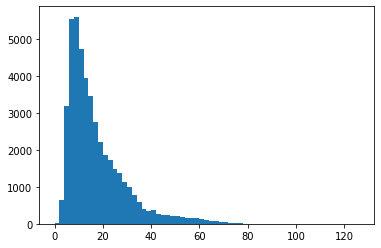

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data_dialect.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data_dialect.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

## Let's select 32 as our maximum sentence length, and check how many sequences will be truncated

In [ ]:
max_len = 32
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data_dialect.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data_dialect.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  4428
Truncated testing sequences:  4428


4428 out of ~45492 for tasting & 4428 out of ~409419 for training isn't bad, as to make training faster for 16 batch size to work

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                       do_lower_case=False, 
                                                       do_basic_tokenize=True)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(data_dialect.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    data_dialect.train[DATA_COLUMN].to_list(),
    data_dialect.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    data_dialect.test[DATA_COLUMN].to_list(),
    data_dialect.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'TN': 0, 'YE': 1, 'MA': 2, 'SD': 3, 'IQ': 4, 'DZ': 5, 'SY': 6, 'OM': 7, 'BH': 8, 'AE': 9, 'LB': 10, 'JO': 11, 'SA': 12, 'QA': 13, 'KW': 14, 'EG': 15, 'LY': 16, 'PL': 17}


In [ ]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 46691, 648, 9355, 330, 566, 1606, 841, 5004, 2107, 3019, 303, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=8)


In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    #print(classification_report(p.label_ids,preds))
    #print(confusion_matrix(p.label_ids,preds))
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    #macro_precision = precision_score(p.label_ids,preds,average='macro')
    #macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
    }

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False # turned from True to False
    torch.backends.cudnn.benchmark = False

# **Regular Training**

In [ ]:
training_args = TrainingArguments( 
    output_dir= "/content/drive/MyDrive/CIT_DL_project/arabert_training/train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 10,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [ ]:
#start the training
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 409419
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 127940
  Number of trainable parameters = 135207186


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,1.589200,1.532137,0.476618,0.512398
1,1.409600,1.440816,0.511122,0.541084
2,1.263100,1.417609,0.527257,0.555658
3,1.109600,1.437852,0.531931,0.558867
4,1.002000,1.486095,0.535463,0.559527
5,0.858300,1.538985,0.538367,0.562165
6,0.771500,1.623263,0.535877,0.560472


***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-12794
Configuration saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-12794/config.json
Model weights saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-12794/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-25588
Configuration saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-25588/config.json
Model weights saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-25588/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-38382
Co

# **Resume training from checkpoint**

In [ ]:
trainer.train(resume_from_checkpoint = True)

Loading model from /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-89558.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 409419
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 127940
  Number of trainable parameters = 135207186
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 89558
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` f

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
7,0.664200,1.698493,0.534026,0.555944
8,0.607700,1.774212,0.531737,0.555724
9,0.553500,1.813289,0.531890,0.556493


***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-102352
Configuration saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-102352/config.json
Model weights saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-102352/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-115146
Configuration saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-115146/config.json
Model weights saved in /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-115146/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 45492
  Batch size = 128
Saving model checkpoint to /content/drive/MyDrive/CIT_DL_project/arabert_training/train/checkpoint-12

TrainOutput(global_step=127940, training_loss=0.18090361523147447, metrics={'train_runtime': 6271.9999, 'train_samples_per_second': 652.773, 'train_steps_per_second': 20.399, 'total_flos': 6.733615680262771e+16, 'train_loss': 0.18090361523147447, 'epoch': 10.0})

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("/content/drive/MyDrive/CIT_DL_project/arabert_training/output_dir")
train_dataset.tokenizer.save_pretrained("/content/drive/MyDrive/CIT_DL_project/arabert_training/output_dir")

In [ ]:
# !cp -R /content/train /content/drive/MyDrive/CIT_DL_project/arabert_training